# Sentiment Analysis on aggregated data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_columns', None) 

In [2]:
df = pd.read_csv('aggregated.csv', index_col = [0])

In [37]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

KeyboardInterrupt: 

In [4]:
#sample sentiment analysis
sample_review = list(df['review_text'])[1]
result = sentiment_pipeline(sample_review)
result

[{'label': 'positive', 'score': 0.9277957677841187}]

In [5]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

sentiment = []
index = -1
for sentence in df['review_lower']:
    index+=1
    if(index%20 == 0):
        print(index)

    result = sentiment_pipeline(sentence[:512])[0]
    sentiment.append(result['label'])
df['sentiment'] = sentiment

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380


# Zero shot classification

In [6]:
import transformers
from transformers import pipeline
classifier  = pipeline("zero-shot-classification",  model = "facebook/bart-large-mnli")

# Sample classification

In [7]:
sample_review = list(df['review_text'])[1]

res = classifier(
    sample_review,
    candidate_labels = ['affordability', 'quality', 'satisfaction', 'complaints'], 
    multi_label = True
)
res

{'sequence': 'The seeds mix is good',
 'labels': ['quality', 'satisfaction', 'affordability', 'complaints'],
 'scores': [0.9990378618240356,
  0.9383894801139832,
  0.027669671922922134,
  0.0002322024229215458]}

# Insert four labels (cost, efficient, effective, ease of use)

In [8]:
type = ['cost', 'efficient', 'effective', 'ease of use']

In [9]:
#setting empty values for the columns
index = -1
for label in type:
    df[label + '_m'] = -1

for j in range(len(df)):
    #counter for progress/debugging
    index+=1
    if(index%20 == 0): 
        print(index)
        
    #running the classifier on the column    
    res = classifier(
        df.iloc[j]['review_lower'],
        candidate_labels = type,
        multi_label = True
    )
    #setting the column values according to the output from the classifier ("_m" = multiclass)
    for i in range(len(res['labels'])):
        df[res['labels'][i]+ '_m'].iloc[j] = res['scores'][i]

0


C:\Users\Woon\AppData\Local\Temp\ipykernel_28716\576072882.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[res['labels'][i]+ '_m'].iloc[j] = res['scores'][i]


20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380


# Metric and sanity check

['the seeds mix is good']

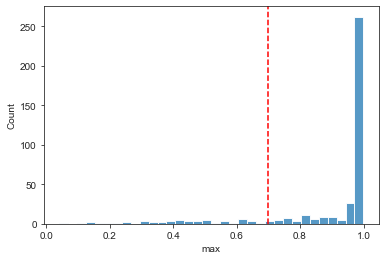

In [10]:
# create a "max" column for metric purposes
df['max'] = df[['cost_m', 'efficient_m', 'effective_m', 'ease of use_m']].max(axis=1)

# append type to max
align_list=[]
for i in range(len(df)):
  for t in type:
    if df[t+'_m'].iloc[i] == df['max'].iloc[i]:
      align_list.append(t)
      
df['align_type']=align_list
sns.set_style('ticks');
fig, ax = plt.subplots();
ax = sns.histplot(x = 'max', data = df);
plt.axvline(0.7, 0,700, c = 'r', ls = '--');

list(df[df['max'] > 0.7]['review_lower'][1:2])

# How many remained uncategorized

In [11]:
# to see how many uncategorized data remains
df_uncat = df[df['cost_m'] < 0.7]
df_uncat = df_uncat[df_uncat['efficient_m'] < 0.7]
df_uncat = df_uncat[df_uncat['effective_m'] < 0.7]
df_uncat = df_uncat[df_uncat['ease of use_m'] < 0.7]
len(df_uncat)

53

# Heatmap

<Figure size 864x360 with 0 Axes>

[Text(0.5, 17.5, ''), Text(80.5, 0.5, '')]

[Text(0.5, 17.5, ''), Text(80.5, 0.5, '')]

[Text(0.5, 17.5, ''), Text(80.5, 0.5, '')]

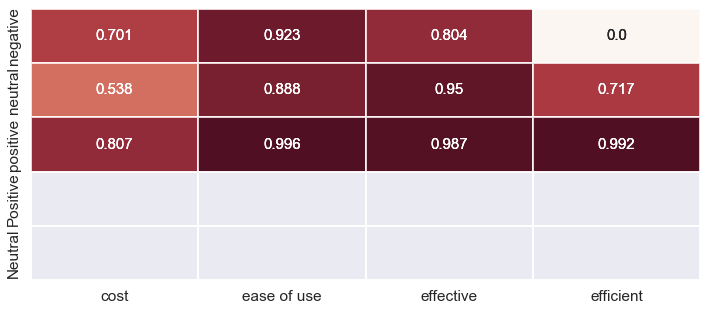

In [12]:
table = pd.pivot_table(df, values='max', index=['sentiment'], columns=['align_type'], aggfunc=np.mean,fill_value=0)
plt.figure(figsize=(12, 5))
sns.set(font_scale=1.4)
# Reds
data1 = table.copy()
data1.loc['Negative'] = float('nan')
data1.loc['Neutral'] = float('nan')
ax=sns.heatmap(data1, annot=True, cmap="Greens", alpha=0.75,fmt=".3",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

# Blue
data2 = table.copy()
data2.loc['Negative'] = float('nan')
data2.loc['Positive'] = float('nan')
ax=sns.heatmap(data2, annot=True, cmap="Blues", alpha=0.75,fmt=".3",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")
# Greens
data3 = table.copy()
data3.loc['Positive'] = float('nan')
data3.loc['Neutral'] = float('nan')
ax=sns.heatmap(data3, annot=True, cmap="Reds", alpha=0.75,fmt=".3",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

# Accuracy evaluation

In [38]:
df = pd.read_csv('aggregated_handlabeled.csv', index_col = [0])
#replace NaN in label columns with 0
columns = ['cost','ease of use', 'effective', 'efficient']

for column in columns:
    df[column] = df[column].replace(np.nan, int(0))

In [39]:
# sentiment analysis
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

sentiment = [None] * len(df)
index = -1
for sentence in df['review_lower'][0:99]:
    index+=1
    if(index%20 == 0):
        print(index)

    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
df['sentiment_m'] = sentiment

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
20
40


60
80


In [40]:
# zero-shot classifier
classifier  = pipeline("zero-shot-classification",  model = "facebook/bart-large-mnli")
type = ['cost', 'efficient', 'effective', 'ease of use']
#setting empty values for the columns
index = -1
for label in type:
    df[label + '_m'] = -1

for j in range(99):
    #counter for progress/debugging
    index+=1
    if(index%20 == 0): 
        print(index)
        
    #running the classifier on the column    
    res = classifier(
        df.iloc[j]['review_lower'],
        candidate_labels = type,
        multi_label = True
    )
    #setting the column values according to the output from the classifier ("_m" = multiclass)
    for i in range(len(res['labels'])):
        df[res['labels'][i]+ '_m'].iloc[j] = res['scores'][i]

0


C:\Users\Woon\AppData\Local\Temp\ipykernel_28716\2091210579.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[res['labels'][i]+ '_m'].iloc[j] = res['scores'][i]


20
40
60
80


In [41]:
df

,segment,review_id,product_name,producturl,retailer,brand,retailer_product_id,base_id,variants_flag,review_creation_date,year,month,week,review_title,review_text,review_type,price,rating,images,videos,helpful_votes,promotion_flag,review_lower,date,word_count,sentiment,cost,ease of use,effective,efficient,sentiment_m,cost_m,efficient_m,effective_m,ease of use_m
4883,Garden,55829,AMDRO Ant Block Home Perimeter Ant Bait 24oz,https://www.lowes.com/pd/AMDRO-Ant-Block-24-oz...,Lowes,Amdro,1000044709,1000044709,No,2021-06-03T00:00:00,2021,6,22,Problem solver,Great product. We had huge problem with ants e...,organic reviews,9.47,5,0,0,0,No,great product. we had huge problem with ants e...,6/3/2021,23,positive,0.0,0.0,1.0,1.0,positive,0.498742,0.980484,0.998226,0.773456
3551,Garden,33176,Pennington Wild Bird Food,http://www.homedepot.com/p/t/312026386,Homedepot,Pennington Bird,312026386,312026384,Yes,2021-06-09T00:00:00,2021,6,23,The seeds mix is good...,The seeds mix is good,organic reviews,12.98,2,0,0,0,No,the seeds mix is good,6/9/2021,5,positive,0.0,0.0,1.0,0.0,positive,0.003480,0.951615,0.997619,0.347957
2545,Garden,22333,Centipede Seed With Mulch 5lb bag,http://www.homedepot.com/p/t/100598598,Homedepot,Pennington Grass,100598598,100598598,Yes,2021-07-09T00:00:00,2021,7,27,This product was easy spread and have covered ...,This product was easy spread and have covered ...,organic reviews,39.64,5,0,0,0,No,this product was easy spread and have covered ...,7/9/2021,19,positive,0.0,1.0,1.0,1.0,positive,0.375175,0.992700,0.997839,0.993937
614,Garden,4312,Sevin Lawn Insect Granules 10 lb.,https://www.amazon.com/Sevin-Lawn-Insect-Granu...,Amazon,GardenTech,B000RUAR0G,B000RUAR0G,No,2021-07-03T00:00:00,2021,7,26,Use as directed,"When I first purchased this bag, bugs kept eat...",organic reviews,19.00,5,0,0,1,No,"when i first purchased this bag, bugs kept eat...",7/3/2021,64,positive,0.0,0.0,1.0,0.0,neutral,0.753738,0.745869,0.986058,0.543351
19,Garden,244,AMDRO Fire Ant Bait 2lb,https://www.amazon.com/dp/B002FYMTB2,Amazon,Amdro,B002FYMTB2,B002FYMTB2,No,2021-06-13T00:00:00,2021,6,23,Very Effective for Harvester Ants,Actually kills Harvester Ants! We have struggl...,organic reviews,20.59,5,0,0,0,No,actually kills harvester ants! we have struggl...,6/13/2021,37,positive,0.0,0.0,1.0,1.0,negative,0.712010,0.990643,0.999461,0.623998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,Garden,6333,Lawn Booster Sun & Shade 9.6lb bag,https://www.amazon.com/dp/B084NMGHK7,Amazon,Pennington Grass,B084NMGHK7,B084NMGHK7,No,2021-06-30T00:00:00,2021,6,26,Great,Its is good,organic reviews,15.88,3,0,0,0,No,its is good,6/30/2021,3,NaN,0.0,0.0,0.0,0.0,None,-1.000000,-1.000000,-1.000000,-1.000000
9851,Garden,70548,Pennington Wild Bird Food Blend Bucket,http://www.homedepot.com/p/312026384,Homedepot,Pennington Bird,312026398,312026384,Yes,2021-12-17T00:00:00,2021,12,50,Poor quality,The variety of seed is pretty poor. Overloaded...,organic reviews,22.98,2,0,0,1,No,the variety of seed is pretty poor. overloaded...,12/17/2021,22,NaN,0.0,0.0,0.0,0.0,None,-1.000000,-1.000000,-1.000000,-1.000000
23479,Garden,135531,"Pennington Smart Patch Bermudagrass Mix, 5 lb Jug",https://www.lowes.com/pd/Pennington-Smart-Patc...,Lowes,Pennington Grass,5005478639,5005478639,No,2022-05-12T00:00:00,2022,5,19,Beautiful Grass,[This review was collected as part of a promot...,syndicated reviews,11.98,5,0,0,0,Yes,[this review was collected as part of a promot...,5/12/2022,49,NaN,0.0,0.0,0.0,0.0,None,-1.000000,-1.000000,-1.000000,-1.000000
15375,Garden,90659,Pennington Ready-to-Use Hummingbird Food 64oz,https://www.walmart.com//ip/Pennington-Ready-t...,Walmart,Pennington Bird,471014069,471014069,No,2022-04-16T00:00:00,2022,4,15,Easy buy.,I like that I can buy a pre made formula to fe...,organic reviews,5.74,5,0,0,0,No,i like that i can buy a pre made formula to fe...,4/16/2022,77,NaN,0.0,0.0,0.0

## Evaluate sentiment

In [42]:
# Evaluate sentiment
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
def imputation1(list):
    i = []
    for prediction in list:
        if prediction == "positive":
            i.append(1)
        elif prediction == "neutral":
            i.append(0)
        else:
            i.append(-1)    
    return(i)
df['sentiment'] = imputation1(df['sentiment'])
df['sentiment_m'] = imputation1(df['sentiment_m'])
print(classification_report(df['sentiment'], df['sentiment_m']))

              precision    recall  f1-score   support

          -1       0.98      0.99      0.99       324
           0       0.33      0.33      0.33        12
           1       0.95      0.88      0.91        64

    accuracy                           0.95       400
   macro avg       0.75      0.73      0.74       400
weighted avg       0.95      0.95      0.95       400



## Evaluate zero shot

In [43]:
# Evaluate zero-shot
def imputation(list):
    i = []
    for prediction in list:
        if prediction < 0.7:
            i.append(0)
        else:
            i.append(1)
    
    return(i)
df['cost_m'] = imputation(df['cost_m'])
df['efficient_m'] = imputation(df['efficient_m'])
df['effective_m'] = imputation(df['effective_m'])
df['ease of use_m'] = imputation(df['ease of use_m'])

### 1) cost

In [44]:
print(classification_report(df['cost'], df['cost_m']))

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97       388
         1.0       0.38      0.92      0.54        12

    accuracy                           0.95       400
   macro avg       0.69      0.94      0.76       400
weighted avg       0.98      0.95      0.96       400



In [45]:
ROC_AUC = roc_auc_score(df['cost'], df['cost_m'])
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.9351


### 2) efficient

In [46]:
print(classification_report(df['efficient'], df['efficient_m']))

              precision    recall  f1-score   support

         0.0       0.96      0.89      0.93       363
         1.0       0.38      0.65      0.48        37

    accuracy                           0.87       400
   macro avg       0.67      0.77      0.70       400
weighted avg       0.91      0.87      0.88       400



In [47]:
ROC_AUC = roc_auc_score(df['efficient'], df['efficient_m'])
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.7706


### 3) effective

In [48]:
print(classification_report(df['effective'], df['effective_m']))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96       306
         1.0       0.97      0.73      0.84        94

    accuracy                           0.93       400
   macro avg       0.95      0.86      0.90       400
weighted avg       0.94      0.93      0.93       400



In [49]:
ROC_AUC = roc_auc_score(df['effective'], df['effective_m'])
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.8638


### 4) ease of use

In [50]:
print(classification_report(df['ease of use'], df['ease of use_m']))

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96       381
         1.0       0.34      0.74      0.47        19

    accuracy                           0.92       400
   macro avg       0.66      0.83      0.71       400
weighted avg       0.96      0.92      0.93       400



In [51]:
ROC_AUC = roc_auc_score(df['ease of use'], df['ease of use_m'])
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.8330


## Compare zero-shot against a Naive classifier

In [52]:
def naive(list):
    avg  = np.mean(list)

    if avg >= 0.5:
        i = 1
    else:
        i = 0

    return([i] * len(list))
df['naive_cost'] = naive(df['cost'])
df['naive_efficient'] = naive(df['efficient'])
df['naive_effective'] = naive(df['effective'])
df['naive_easeofuse'] = naive(df['ease of use'])

In [53]:
# cost
print(classification_report(df['cost'], df['naive_cost']))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       388
         1.0       0.00      0.00      0.00        12

    accuracy                           0.97       400
   macro avg       0.48      0.50      0.49       400
weighted avg       0.94      0.97      0.96       400



c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [54]:
# efficient
print(classification_report(df['efficient'], df['naive_efficient']))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       363
         1.0       0.00      0.00      0.00        37

    accuracy                           0.91       400
   macro avg       0.45      0.50      0.48       400
weighted avg       0.82      0.91      0.86       400



c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [55]:
# effective
print(classification_report(df['effective'], df['naive_effective']))

              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87       306
         1.0       0.00      0.00      0.00        94

    accuracy                           0.77       400
   macro avg       0.38      0.50      0.43       400
weighted avg       0.59      0.77      0.66       400



c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [56]:
# ease of use
print(classification_report(df['ease of use'], df['naive_easeofuse']))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98       381
         1.0       0.00      0.00      0.00        19

    accuracy                           0.95       400
   macro avg       0.48      0.50      0.49       400
weighted avg       0.91      0.95      0.93       400



c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [57]:
df.to_csv('aggregated_evaluation.csv')

# Visualization

In [58]:
report_sentiment = classification_report(df['sentiment'], df['sentiment_m'], output_dict=True)

def accuracy(type):
  report = classification_report(df[type], df[type+'_m'], output_dict=True)
  return (type, report['accuracy'])

def accuracy_matrix(type):
  report = classification_report(df[type], df[type+'_m'], output_dict=True)
  data= np.ones((100, 100))
  data[0:int(report_sentiment['accuracy']*100),0:int(report['accuracy']*100)] = 0.0 
  return data

In [59]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.ticker as mticker  
import matplotlib.patches as mpatches

Text(0.5, 0, 'cost accuracy')

Text(0, 0.5, 'sentiment accuracy')

Text(0, 0.5, 'sentiment accuracy')

Text(0.5, 0, 'ease of use accuracy')

Text(0.5, 0, 'effectiveness accuracy')

Text(0.5, 0, 'efficiency accuracy')

Text(40, 45, 'Accuracy: 90.96%')

Text(40, 45, 'Accuracy: 87.86%')

Text(40, 45, 'Accuracy: 89.05%')

Text(40, 45, 'Accuracy: 83.08%')

[]

[]

[]

[]

[]

[]

[]

[]

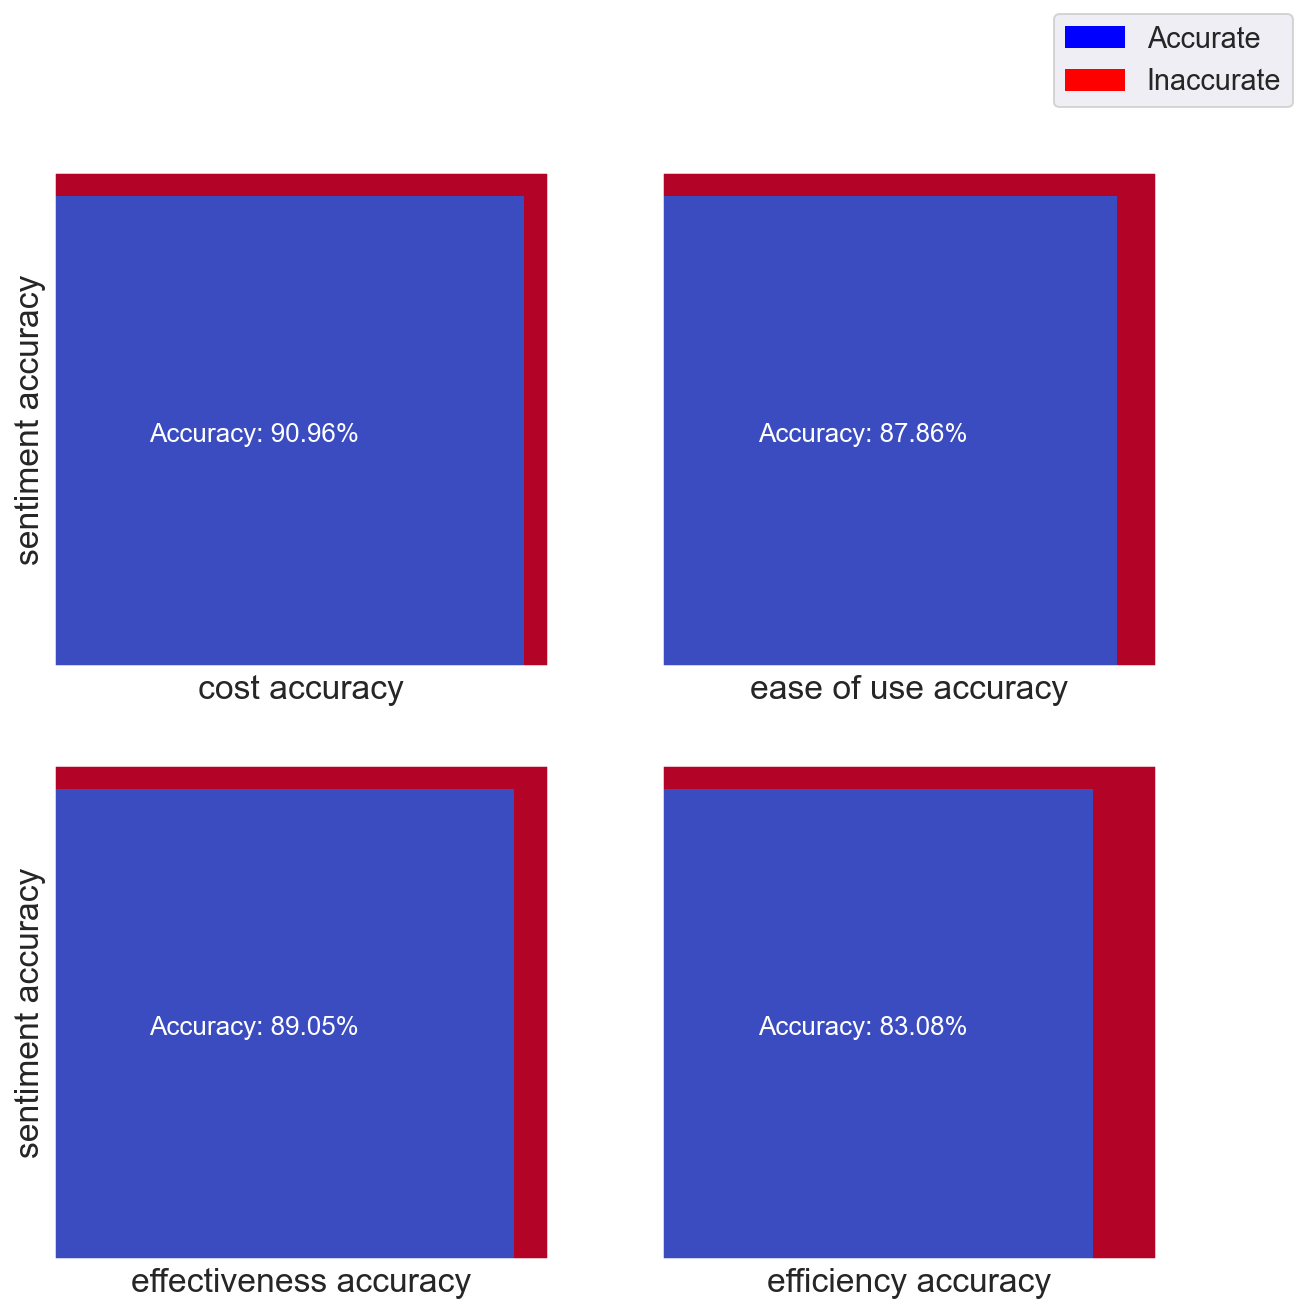

In [62]:
#fig, ax = plt.subplots()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True)

fig.set_figheight(10)
fig.set_figwidth(10)

img1 = ax1.imshow(accuracy_matrix('cost'),cmap='coolwarm',origin='lower')
img2 = ax2.imshow(accuracy_matrix('ease of use'),cmap='coolwarm',origin='lower')
img3 = ax3.imshow(accuracy_matrix('effective'),cmap='coolwarm',origin='lower')
img4 = ax4.imshow(accuracy_matrix('efficient'),cmap='coolwarm',origin='lower')

img1=plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
img1=plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter())

ax1.set_xlabel('cost accuracy')
ax1.set_ylabel('sentiment accuracy')
ax3.set_ylabel('sentiment accuracy')
ax2.set_xlabel('ease of use accuracy')
ax3.set_xlabel('effectiveness accuracy')
ax4.set_xlabel('efficiency accuracy')

ax1.text(40, 45, 'Accuracy: '+ str(round(report_sentiment['accuracy']*accuracy('cost')[1]*100,2))+'%', fontsize=13, c='white',ha='center')
ax2.text(40, 45, 'Accuracy: '+ str(round(report_sentiment['accuracy']*accuracy('ease of use')[1]*100,2))+'%', fontsize=13, c='white',ha='center')
ax3.text(40, 45, 'Accuracy: '+ str(round(report_sentiment['accuracy']*accuracy('effective')[1]*100,2))+'%', fontsize=13, c='white',ha='center')
ax4.text(40, 45, 'Accuracy: '+ str(round(report_sentiment['accuracy']*accuracy('efficient')[1]*100,2))+'%', fontsize=13, c='white',ha='center')

ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])

blue_patch = mpatches.Patch(color='blue', label='Accurate')
red_patch = mpatches.Patch(color='red', label='Inaccurate')
fig.legend(handles=[blue_patch, red_patch],loc='upper right',fontsize='x-large')